# Summary

### 1. Preface

As of now we plan to keep this thing in a Jupyter Notebook and have it available via myBinder (an online jupyter notebook 'compiler'). If by any chance you are familiar with languages like JavaScript, feel free to make it an actual webpage if possible.

To have a Jupyter Notebook running on myBinder, the associated python version and the version of any library you need to import have to be specified. The runtime.txt file specifies python version, and the requirements.txt file lists out libraries. Again, these two .txt files are only for myBinder (ie. you don't have to touch them if you are only testing out things on your own device).

I'm assuming basic familiarity with the Robinson&Catling 2012 paper, especially section 2. All reference to equations/figures with numbers are from this paper.

The Robinson & Catling 2012 paper mentioned three cases of the radiative convective model: the simplest case without starlight attenuation (k1=k2=0), the single channel with attenuation case, and the complete case where we have two shortwave channels with attenuation. 

For each of these cases, a system of equations needs to be solved. And with user defined parameters + solved parameters, we can calculate the T-P profile both in the radiative region and in the convective region.

#### models.py 
It contains most of the calculations, more specifically:
- Three functions (one for each case) solving the system of equations, see comments in this .py file for more details;
- Two functions that calculate temperature given pressure (and other parameters), one for radaitive and one for convective.

#### plotting.py
It contains one function that takes all user input parameters and generates a T-P plot if possible. It also includes some error handling, so for example, if a certain function argument does not make sense (eg. is negative while it shouldn't be), the function stops trying to generate the plot. I'm not quite familiar with "common practice" in coding, and you'll see that my error handling is just a series of simple if-statement. for now.

#### widget_plot.py
It basically decides how the enter boxes look like: default values, layout, parameter names/descriptions, etc. (I put comments for basically all lines).

#### Here below is an all-in-one notebook (three .py files gathered)

### 2. Math

In [1]:
#import libraries needed for the calculations
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.special import gamma, gammaincc
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("error")

In [3]:
#constants
D = 1.66 #this is mentioned in the paper
sigma = 5.67e-8

Equation (13) in Robinson & Catling (2012) reads: $$F^+(\tau)=\sigma T_0^4e^{D\tau}\left[e^{-D\tau_0}+\frac{1}{(D\tau_0)^{4\beta/n}}\left(\Gamma\left(1+\frac{4\beta}{n},D\tau\right)-\Gamma\left(1+\frac{4\beta}{n},D\tau_0\right)\right)\right],$$ (where the incomplete Gamma function as defined in Appendix is:$$\Gamma(a,x)\equiv \int_x^{\infty}t^{a-1}e^{-t}dt,$$ whereas scipy.special.gammaincc(a,x) computes:$$Q(a,x)=\frac{1}{\Gamma (a)}\int_x^{\infty}t^{a-1}e^{-t}dt\Rightarrow \Gamma(a,x)=Q(a,x)\Gamma (a);$$)

which, at $\tau=\tau_\mathrm{rc}$, must agree with (equation 19):$$F^+(\tau)=\frac{F_1}{2}\left[1+\frac{D}{k_1}+\left(1-\frac{D}{k_1}\right)e^{-k_1\tau}\right]+\frac{F_2}{2}\left[1+\frac{D}{k_2}+\left(1-\frac{D}{k_2}\right)e^{-k_2\tau}\right]+\frac{F_i}{2}(2+D\tau).$$

So the first equality is:
\begin{equation}\sigma T_0^4e^{D\tau_\mathrm{rc}}\left[e^{-D\tau_0}+\frac{1}{(D\tau_0)^{4\beta/n}}\left(\Gamma\left(1+\frac{4\beta}{n},D\tau_\mathrm{rc}\right)-\Gamma\left(1+\frac{4\beta}{n},D\tau_0\right)\right)\right]=\frac{F_1}{2}\left[1+\frac{D}{k_1}+\left(1-\frac{D}{k_1}\right)e^{-k_1\tau_\mathrm{rc}}\right]+\frac{F_2}{2}\left[1+\frac{D}{k_2}+\left(1-\frac{D}{k_2}\right)e^{-k_2\tau_\mathrm{rc}}\right]+\frac{F_i}{2}(2+D\tau_\mathrm{rc})
\end{equation}

And the second one (equation 21):$$\sigma T_0^4\left(\frac{\tau_\mathrm{rc}}{\tau_0}\right)^{4\beta/n}=\frac{F_1}{2}\left[1+\frac{D}{k_1}+\left(\frac{k_1}{D}-\frac{D}{k_1}\right)e^{-k_1\tau_\mathrm{rc}}\right]+\frac{F_2}{2}\left[1+\frac{D}{k_2}+\left(\frac{k_2}{D}-\frac{D}{k_2}\right)e^{-k_2\tau_\mathrm{rc}}\right]+\frac{F_i}{2}(2+D\tau_\mathrm{rc})$$

with relevant parameters: $T_0$, $\tau_\mathrm{rc}$, $\tau_0$, $\alpha$, $\gamma$, $n$, $F_1$, $k_1$, $F_2$, $k_2$, $F_i$; and with the relationship $$\tau=\tau_0\left(\frac{p}{p_0}\right)^n.$$ This gives the first function that solves $\tau_0$ and $\tau_\mathrm{rc}$ using user defined (throught enter boxes above the plotting zone) parameters:

In [6]:
def taus(p0, T0, n, ga, a, 
         F1, F2, Fi, k1, k2, kir, 
         g, taurcest=1):
    """
    Calculates optical depth at reference level and at the rc boundary
    for two short-wave channels with attenuation.
    
    Parameters
    input (floats):
    p0: air pressure at reference level [bar]
    T0: temperature at reference level [K]
    n: pressure-IR optical depth scaling parameter, unitless
    ga: ratio of specific heats (cp/cv) 
        depending on air constituents, unitless
    a: average ratio of true lapse rate vs. 
        dry adiabatic lapse rate, unitless
    Fi: internal flux [W/m^2]
    F1(F2): TOA absorbed stellar flux in short-wave channel 1(2) [W/m^2]
    k1(k2): ratio of short-wave attenuation in channel 1(2)
            vs. thermal attenuation, unitless
    kir: gray infrared extinction coefficient [m^2/kg]
    g: planetary gravitationnal acceleration, 
        used for optical depth estimation [m/s^2]
    taurcest: roughly estimated optical depth at rc boundary, unitless
        
    output:
        optical depths at reference level & at rc boundary
    """
    #4b/n factor
    bn = 4*(a*(ga-1)/ga)/n
    
    def equations(t):
        tau0, taurc = t
        return ((F1/2.)*(1+D/k1+(1-D/k1)*sp.exp(-k1*taurc))+\
               (F2/2.)*(1+D/k2+(1-D/k2)*sp.exp(-k2*taurc))+\
               (Fi/2)*(2+D*taurc)-\
               sigma*T0**4*sp.exp(D*taurc)*(sp.exp(-D*tau0)+(1/(D*tau0)**bn)*\
               (gammaincc(1+bn,D*taurc)*gamma(1+bn)-gammaincc(1+bn,D*tau0)*gamma(1+bn))),
               (F1/2.)*(1+D/k1+(k1/D-D/k1)*sp.exp(-k1*taurc))+\
               (F2/2.)*(1+D/k2+(k2/D-D/k2)*sp.exp(-k2*taurc))+\
               (Fi/2)*(2+D*taurc)-\
               sigma*T0**4*(taurc/tau0)**bn)
    
    
    #kir: thermal extinction coefficient at p0, 
    #tau0 = kir(at p0) * p0/g
    #Using the 'plug' relation the estimate a tau0 (optical depth at reference level)
    
    tau0est = kir*p0*100000/g #100000 for bar to Pa conversion, the paper uses bar for pressure
    
    #error catching so that the codes don't show random red error messages
    try:
        solutions = fsolve(equations,(tau0est,taurcest))
    except RuntimeWarning:
        print("No solution")
        return (-9999, -9999)

        
    print("Two short-wave channels with attenuation.")
    
    return (solutions)

The numerical solver that we currently use, scipy.optimize.fsolve, requires estimates for the variable you are trying to solve (this is the case for most (all?) numerical solver I believe). For the system of equations we have here, setting fixed estimates does not work well for large variation in atmospheric properties. Now we try to estimate $\tau_0$, the optical depth at reference level, using the 'plug' relation you've learned in Climate Physics. So $$\tau_0 = \kappa_\rm{IR}\cdot p_0/g.$$ As for $\tau_\rm{RC}$ the optical depth at RC boundary, we are basically asking the user to try entering different values until the solver finds a solution (which is really inefficient and weird). Following are two other cases:

In [5]:
def simpleRC(p0, T0, n, ga, a, F, Fi, kir, g, taurcest=1):
    """
    Calculates optical depth at reference level and at the rc boundary
    for the single channel without attenuation.
    
    Parameters (different from above)
    input (float):
    F: TOA absorbed net stellar flux (sum of F1 and F2) [W/m^2]
    """
    bn = 4*(a*(ga-1)/ga)/n
    
    def equations(t):
        tau0, taurc = t
        return ((F+Fi)*(1+D*taurc)/2. - sigma*T0**4*(taurc/tau0)**bn,
               sigma*T0**4*sp.exp(D*taurc)*(sp.exp(-D*tau0)+(1/(D*tau0)**bn)*\
               (gammaincc(1+bn,D*taurc)*gamma(1+bn)-gammaincc(1+bn,D*tau0)*gamma(1+bn)))-\
               (2+D*taurc)*(F+Fi)/2.)
    
    tau0est = kir*p0*100000/g
    
    try:
        solutions = fsolve(equations,(tau0est,taurcest))
    except RuntimeWarning:
        print("No solution")
        return (-9999, -9999)
    
    print("Simplest case without short-wave attenuation.")
    
    return (solutions)

def single_atten(p0, T0, n, ga, a, F, Fi, k, kir, g, taurcest=1):
    """
    Calculates optical depth at reference level and at the rc boundary
    for the single channel model with attenuation.
    
    Parameters (different from above)
    input (float):
    F: TOA absorbed net stellar flux [W/m^2]
    k: ratio of short-wave attenuation vs. thermal attenuation, unitless
    """
    bn = 4*(a*(ga-1)/ga)/n
    
    def equations(t):
        tau0, taurc = t
        return ((F/2.)*(1+D/k+(1-D/k)*sp.exp(-k*taurc))+\
               (Fi/2)*(2+D*taurc)-\
               sigma*T0**4*sp.exp(D*taurc)*(sp.exp(-D*tau0)+(1/(D*tau0)**bn)*\
               (gammaincc(1+bn,D*taurc)*gamma(1+bn)-gammaincc(1+bn,D*tau0)*gamma(1+bn))),
               (F/2.)*(1+D/k+(k/D-D/k)*sp.exp(-k*taurc))+\
               (Fi/2)*(2+D*taurc)-\
               sigma*T0**4*(taurc/tau0)**bn)
    
    tau0est = kir*p0*100000/g
    
    try:
        solutions = fsolve(equations,(tau0est,taurcest))
    except RuntimeWarning:
        print("No solution")
        return (-9999, -9999)
    
    print("Single short-wave channel with attenuation.")
    
    return (solutions)

Now we have the functions to calculate temperature given a pressure value:

In [7]:
def Erad(p, p0, n, F1, F2, Fi, k1, k2, tau0):#radiative region
    #The "if" case is equation 24
    #The "else" case is equation 18
    #The "elif" cases are reduced from equation 18 
    #(Robinson&Catling 2012)
    
    tau = tau0*(p/p0)**n
    F = F1+F2 #in the single channel case we only have one Flux
    
    
    if k1 == 0.0 and k2 == 0.0:#simple case without attenuation
        return (((1+D*tau)*(F+Fi)/2.)/sigma)**(1/4)
    
    elif (k1 != 0.0 and k2 == 0.0):#single channel, user might choose either one
        return ((((F/2)*(1+D/k1+(k1/D-D/k1)*np.exp(-k1*tau))+
                (Fi/2)*(1+D*tau))/sigma)**(1/4))
    elif (k1 == 0.0 and k2 != 0.0):#single channel
        return ((((F/2)*(1+D/k2+(k2/D-D/k2)*np.exp(-k2*tau))+
                (Fi/2)*(1+D*tau))/sigma)**(1/4))
    else:
        return ((((F1/2)*(1+D/k1+(k1/D-D/k1)*np.exp(-k1*tau))+
                (F2/2)*(1+D/k2+(k2/D-D/k2)*np.exp(-k2*tau))+
                (Fi/2)*(1+D*tau))/sigma)**(1/4))

def Econv(p, p0, T0, n, ga, a):#convective region
    #equation 10
    return T0*(p/p0)**((a*(ga-1))/ga)

### 3. Plotting

In [8]:
import matplotlib.pyplot as plt

Before diving into the large plotting function, I'll explain the parameters that are different from previous function arguments and from what's described in the paper. As you might have noticed, in the functions above, we used $k_1$/$k_2$ for ratio of short-wave attenuation in channel 1/2 vs. thermal attenuation, consistent with the paper. 

But since we are requiring $\kappa_\rm{IR}$, the gray infrared extinction coefficient, from the user, we have decided that we would also ask for UV extinction coefficient $\kappa_\rm{UV}$ and optical extinction coefficient $\kappa_\rm{op}$ (we are separating the two shortwave channels as UV and optical). To be clear, $k_1$ would just be the ratio $\kappa_\rm{UV}$/$\kappa_\rm{IR}$, and $k_2$ is $\kappa_\rm{op}$/$\kappa_\rm{IR}$.

Again to be clear, we have:
- User enters a $\kappa_\rm{UV}$, a $\kappa_\rm{op}$, and a $\kappa_\rm{IR}$;
- The plotting function calculates the ratio $\kappa_\rm{UV}$/$\kappa_\rm{IR}$, assign the value to a variable named $k_1$;
- The plotting function calculates the ratio $\kappa_\rm{op}$/$\kappa_\rm{IR}$, assign the value to a variable named $k_2$;
- So basically when you see the calculation functions being called in the plotting function, the k1/k2 there has the same definition as described above.

In [9]:
def plot_TP(p0, T0, n, ga, a, F1, F2, Fi, kuv, kop, kir, g, taurcest):
    """
    Plots the corresponding TP profile given user input parameters.
    
    Parameters
    input (strings):
    p0: air pressure at reference level [bar]
    T0: temperature at reference level [K]
    n: pressure-IR optical depth scaling parameter, unitless
    ga: ratio of specific heats (cp/cv) 
        depending on air constituents, unitless
    a: average ratio of true lapse rate vs. 
        dry adiabatic lapse rate, unitless
    Fi: internal flux [W/m^2]
    F1(F2): TOA absorbed stellar flux in short-wave channel 1(2) [W/m^2]
    kuv: extinction coefficient in short-wave channel 1 
        (UV as in Earth's case) [m^2/kg]
    kop: extinction coefficient in short-wave channel 2 
        (optical as in Earth's case) [m^2/kg]
    kir: gray infrared extinction coefficient [m^2/kg]
    g: planetary gravitationnal acceleration, 
        used for optical depth estimation [m/s^2]
    taurcest: roughly estimated optical depth at rc boundary, unitless
    
    output:
        None    
    """
    #Check for most basic valid input
    #Raises error if user input cannot be converted to float
    #locals().items() is a list of all function arguments
    for item in locals().items():
        try:
            float(item[1])#argument value
        except ValueError:
            print(item[0]+' must be a number.')#argument name
            return
        
    #avoiding division by 0 error
    kir = float(kir)
    if kir <= 0.:
        print(r'$\kappa_\mathrm{ir}$ must be strictly positive.')
        return
    
    p0 = float(p0)
    T0 = float(T0)
    n = float(n)
    ga = float(ga)
    a = float(a)
    F1 = float(F1)
    F2 = float(F2)
    Fi = float(Fi)
    k1 = float(kuv)/kir#calculating required ratios
    k2 = float(kop)/kir
    g = float(g)
    taurcest = float(taurcest)
    
    #Handling inputs that don't make sense
    tmp = True
    
    #(F1+F2+Fi)/2=sigma*Tskin^4 sets the lower limit for T0
    #So the temperature at reference level cannot be lower than the skin temperature
    
    #Tskin = ((F1+F2+Fi)/(2*sigma))**(1/4)
    
    if p0 < 0.:
        print('p_0 must be non-negative.')
        tmp = False
    if T0 < 0.:
        print('T_0 must be non-negative.')
        tmp = False
    if (n>2. or n<1.):
        print('n takes value between 1 and 2.')
        tmp = False
    if (ga>2. or ga<1.):
        print('γ takes value between 1 and 2.')
        tmp = False
    if (a>1. or a<0.):
        print('α takes value between 0 and 1.')
        tmp = False
    if (F1<0. or F2<0. or Fi<0):
        print('All fluxes must be non-negative.')
        tmp = False
    if (k1<0. or k2<0.):
        print('All κ must be non-negative.')
        tmp = False
    if g<0.:
        print('g must be non-negative.')
        tmp = False
    if taurcest<0.:
        print('Est. τ must be non-negative.')
        tmp = False
    """
    Attempting to put higher level restrictions, other than these obvious ones
    eg.
    if T0 < Tskin:
        print('The entered temperature at reference level (T0)\n 
        is lower than the atmospheric skin temperature.')
        tmp = False
    """          
    if not tmp:
        return
            
            
    
    fig, ax1 = plt.subplots(figsize=(7,5))
    ax2 = ax1.twinx()#for y-axes on both sides
        
    if k1 == 0.0000 and k2 == 0.0000:#simple case
        tau0, taurc = simpleRC(p0, T0, n, ga, a, F1+F2, Fi, kir, g, taurcest)   
    elif (k1 != 0.0000 and k2 == 0.0000):#single channel with attenuation
        #Assumption: users may choose either uv or optical as the single shortwave-channel
        tau0, taurc = single_atten(p0, T0, n, ga, a, F1+F2, Fi, k1, kir, g, taurcest)
    elif (k1 == 0.0000 and k2 != 0.0000):
        tau0, taurc = single_atten(p0, T0, n, ga, a, F1+F2, Fi, k2, kir, g, taurcest)
    else:#two channels with attenuation, the complete case    
        tau0, taurc = taus(p0, T0, n, ga, a, F1, F2, Fi, k1, k2, kir, g, taurcest)
        
    if tau0 == -9999: #I've set the calculation function to return -9999 when no solution
        return
    
    ps = np.linspace(0.001,p0,10000)
    #the lower limit is set to p0 by default
    #possible to become user-defined, because eg. Figure 6 extends to far below the reference level
    
    
    #Potential possibility to make right vertical axis altitude
    
    ts = tau0*(ps/p0)**n #for the right vertical axis
    
    prc=p0*(taurc/tau0)**(1/n) #pressure at rc boundary
    
    #Calculates temperature profile
    Ts=[]
    for p in ps:#if higher than rc boundary than use the function for radiative region
        #otherwise use convective region one
        if p <= prc:
            Ts.append(Erad(p, p0, n, F1, F2, Fi, k1, k2, tau0))
        else:
            Ts.append(Econv(p, p0, T0, n, ga, a))
    
    #Calculates pressure level corresponding to the minimum temperature
    pmin = ps[Ts.index(min(Ts))]
    #tau_tropopause
    tautp = (pmin/p0)**n*tau0
    
    ax1.semilogy(Ts, ps,'r--')
    
    #generates a vertical axis on the right 
    #this plot is not display and is the same curve as ax1
    ax2.semilogy(Ts, ts, linewidth=0)

    ax1.plot([min(Ts)-20, max(Ts)+20],[prc,prc],'k:',label="RC boundary")
    ax1.plot([min(Ts)-20, max(Ts)+20],[pmin,pmin],linestyle='dashdot',color='k',label="Tropopause")
    
    #plt.title('Atmospheric temperature-pressure profile\n Calculated parameters:'+
     #         r'$\tau_0=$'+
              #str(round(tau0,2))+
              #r', $\tau_\mathrm{rc}=$'+
              #str(round(taurc,2)))
    
    #This is for demonstration purpose, the commented block above shows the solutions
    #returned by the numerical solver for convenience. 
    #You can change the title to that while testing.
    plt.title('Atmospheric temperature-pressure profile\n Temperatures:'+
              r'$T_\mathrm{surf}=$'+
              str(int(T0))+
              r'K , $T_\mathrm{tropo}=$'+
              str(int(min(Ts)))+
              r'K , $T_\mathrm{strato}=$'+
              str(int(Ts[170]))+'K',fontsize=15)
    
    plt.xlim(min(Ts)-20, max(Ts)+20)
    ax1.set_ylim(p0,.001)
    ax2.set_ylim(max(ts),min(ts))
    #ax2.set_ylim(min(zs),max(zs))
    ax1.set_xlabel("Temperature [K]",fontsize=13)
    ax1.set_ylabel("Pressure [bar]",fontsize=13)
    ax2.set_ylabel("Thermal optical depth",fontsize=13)
    #ax2.set_ylabel("Altitude (m)",fontsize=12)

    #Formatting
    plt.tick_params(top=True, right=True, direction='in', which='both')
    ax1.legend(fontsize=12)

    plt.show()

### 4. Making the boxes+plotting zone UI

In [10]:
from ipywidgets import interactive,interact, HBox, Layout,VBox
import ipywidgets as widgets

In addition to Table 1 in Robinson&Catling 2012, another paper by the same authors (http://faculty.washington.edu/dcatling/Robinson2014_0.1bar_Tropopause.pdf) lists out a few more sets of parameters for worlds including the Earth. The default parameters in the cell below are taken from there.

The parameters are of course given in $k_1$/$k_2$ instead of our $\kappa$'s. While testing these codes with examples, I've roughly estimated a $\kappa_\rm{IR}$ for Earth, and multiplied it by those $k_1$/$k_2$ to get UV/optical extinction coefficient. You would have to do such multiplication for each test cases. In future versions it would be ideal to have an option for users to choose to enter $k_1$/$k_2$ or the $\kappa$'s.

(Since what really matters in the calculation is the ratio, and the value of $\kappa_\rm{IR}$ is only used while estimating $\tau_0$, while testing for other atmospheres (with known $\tau$'s, so that you know the system has solution) you can probably put an arbitrary value for $\kappa_\rm{IR}$ and compute other two $\kappa$'s using the given ratio.)

In [11]:
def plotFinal():
    """
    Maybe can add argument for different default planets?
    """
    #The first argument (plot_TP) is the name of the plotting function
    #It means that the following arguments all become plot_TP's arguments
    #Default display/default values 
    #(all values are entered as strings and then converted to floats)
    interactive_plot = interactive(plot_TP, p0='1.', T0='288', n='2.', ga='1.4', a='0.6',
                                   F1='7.', F2='233.', Fi='0.0', kuv='1.6758e-2', kop='2.9792e-5', 
                                   kir='1.86e-4', g='9.8',taurcest = '0.1')
    
    #After entering value into each textbox, either click on another box
    #or hit enter to apply change.
    #If continuous_update was set to true, 
    #the plot will respond in the mean time as you try to enter stuff
    for i in range(13):
        interactive_plot.children[i].continuous_update=False
    
    
    #These are the padding for the text to the left of each box
    #The text that is supposed to be there is actually the long sentences a few lines below,
    #but with padding you can make it display only the part in front of the ':'
    #and user can check full description by mouse-hovering above that abbreviated name
    
    #style1 = {'description_width': '1em'}
    style2 = {'description_width': '2em'}#2em works for most boxes
    style4 = {'description_width': '4em'}
    
    #Description does not show r'$$' formatting
    for i in range(12):
        interactive_plot.children[i].style=style2
        
    interactive_plot.children[0].description=r'$p_0$: Air pressure at reference level [bar]'
    interactive_plot.children[1].description=r'$T_0$: Temperature at reference level [K]'
    interactive_plot.children[2].description=r'$n$: Pressure-IR optical depth scaling factor (unitless)'
    interactive_plot.children[3].description=r'$\gamma$: Ratio of specific heats (cp/cv) of major gas (unitless)'
    interactive_plot.children[4].description=r'$\alpha$: Average ratio of true lapse rate vs. dry adiabatic lapse rate (unitless)'
    interactive_plot.children[5].description=r'$F_1$: TOA absorbed stellar flux in short-wave channel 1 [W/m^2]'
    interactive_plot.children[6].description=r'$F_2$: TOA absorbed stellar flux in short-wave channel 2 [W/m^2]'
    interactive_plot.children[7].description=r'$F_i$: Internal flux [W/m^2]'
    interactive_plot.children[8].description=r'$\kappa_\mathrm{uv}$: Extinction coefficient in short-wave channel 1 [m^2/kg]'
    interactive_plot.children[9].description=r'$\kappa_\mathrm{op}$: Extinction coefficient in short-wave channel 2 [m^2/kg]'
    interactive_plot.children[10].description=r'$\kappa_\mathrm{ir}$: Gray infrared extinction coefficient [m^2/kg]'
    interactive_plot.children[11].description=r'$g$: Planetary gravitationnal acceleration [m/s^2]'
    
    interactive_plot.children[12].description=r'Est. $\tau_\mathrm{rc}$:Roughly estimated optical depth at RC boundary (unitless)'
    interactive_plot.children[12].style=style4

    controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
    output = interactive_plot.children[-1]
    
    display(VBox([controls, output]))

In [13]:
plotFinal()

### 5. Problems

You might have already noticed that this T-P profile generator is hardly functional as of now, since most of the time the solver fails to give solution (when you try arbitrary combination of values). Here below is the email I sent to Dr. Tyler Robinson:

<img src="email.png" align='left'>

His answer:

<img src="response.png" align='left'>

He was basically referring to the process of producing Figure 1 (Section 3.1 in Robinson&Catling 2012), which I believe was part of your Climate Physics coding project (?). 

Equation 30 combines equation 27 and 28, and has its solution contours shown in Figure 1. So if we, say, make an extended version of Figure 1 (you probably had similar codes to reproduce Figure 1 in the coding project):

In [22]:
#the codes below will continue even if the solver fails somewhere
#re-run the first code cell in this notebook if you want to go back to the cells above
warnings.resetwarnings()

In [23]:
Dtaurcs = np.linspace(.01,10.,50)

#Defining equation 30

def incGamma(bn, Dtau):#bn: 4beta/n, Dtau: either tau_0 or tau_rc
    return gammaincc(1+bn,Dtau)*gamma(1+bn)

def F1(Dtau0, Dtaurc, bn):#fsolve solves for the first function argument
    tau0 = Dtau0/D
    taurc = Dtaurc/D
    
    return ((tau0/taurc)**(bn)*np.exp(-Dtau0+Dtaurc)*
            (1+(np.exp(Dtau0)/Dtau0**bn)*(incGamma(bn,Dtaurc)-incGamma(bn,Dtau0)))-
            (2+Dtaurc)/(1+Dtaurc))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


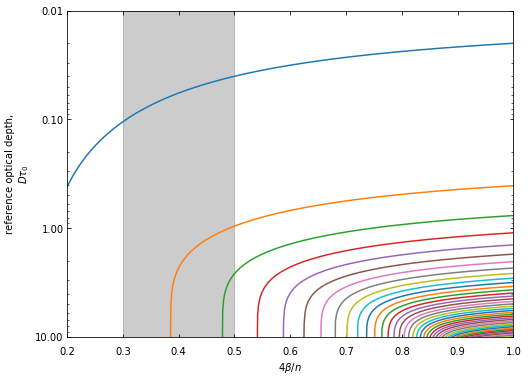

In [24]:
#Plotting 
ratios = []

bns = np.linspace(.2, 1.0, 500)

fig, ax = plt.subplots(figsize=(8,6))

for Dtaurc in Dtaurcs:
    Dtau0s = []
    for bn in bns:
        result = fsolve(F1, [.1],(Dtaurc,bn))
        Dtau0s.append(result)
        ratios.append(((Dtaurc/result)**bn/(1+Dtaurc),result,Dtaurc))
    plt.semilogy(bns, Dtau0s, label = r"$D\tau_\mathrm{rc} =$"+str(Dtaurc))

plt.xlim(.2, 1.0)
plt.ylim(10, 0.01)
plt.xlabel(r"$4\beta/n$")
plt.ylabel("reference optical depth,\n"+r"$D\tau_0$")

plt.axvspan(0.3, 0.5, color='k', alpha=0.2)

#Formatting
plt.tick_params(top=True, right=True, direction='in', which='both')
plt.tick_params(pad=10,axis='x')
ax.set_yticklabels(labels=['0','0.01', '0.10', '1.00', '10.00'])
#plt.legend(bbox_to_anchor=(1, 1))

plt.show()

First, since each point in this plot corresponds to a set of $\tau_0$, $\tau_\rm{RC}$ and 4$\beta/n$, you would expect a corresponding temperature-flux relation for each point (by equation 27). Also, looking at the trend in this plot, we would expect some region in the space that would never be covered by these curves; meaning that there are certain temperature-flux relation that is not allowed. (My work had basically stopped here, so I didn't get a chance to dive deeper into these thoughts.)

So it's maybe possible to come up with some constraints for $T_0$ and $F$ parameters (bound together). When the user enters a combination of these parameters that is physically or mathematically not allowed, the program will display an error message. This approach (for producing Figure 1) might also be useful to discover the constraints related to other combination of parameters.

Another feature that I didn't quite explore is described at the beginning of section 2.5 of the paper. It says that people might want a pair of parameters other than $\tau_0$,$\tau_\rm{rc}$ as unknown parameters.

Feel free to email me (lan.zhu@mail.mcgill.ca) if anything was unclear in this Notebook, and good luck!!!!